In [2]:
import pandas as pd
import numpy as np

## Агрегируем месяда с января по май включтельно в формате количество для [ячейка,час]

In [42]:
def get_aggr_data_from_file(path, date_from, date_to):
    df=pd.read_csv(path,parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'], dayfirst=True)
    df=df[((df['tpep_dropoff_datetime']-df['tpep_pickup_datetime'])/np.timedelta64(1, 's')>0) & \
      (df['passenger_count']>0) & (df['trip_distance']>0) & (df['pickup_latitude']>=40.49612) & \
      (df['pickup_latitude']<=40.91553) & \
      (df['pickup_longitude'] >= -74.25559) & (df['pickup_longitude'] <= -73.70001) ]
    #Создадим таблицу в которой будут все возможные часы месяца и регионы
    regions_hour=pd.read_csv('regions.csv', sep=';')
    tmp=np.datetime64(date_from+' 00:00:00')
    regions_hour['hour']=tmp
    regions_hour2=regions_hour.copy()
    while True:
        tmp=tmp+np.timedelta64(1, 'h')
        if tmp>=np.datetime64(date_to+' 00:00:00'):
            break
        #concat
        regions_hour2['hour']=tmp
        regions_hour=pd.concat([regions_hour, regions_hour2], axis=0)
    #Определим регионы для каждой координаты
    west=-74.25559
    east=-73.70001
    south=40.49612
    north=40.91553
    df['region']=((df['pickup_longitude']-west)/((east-west)/50)).astype(int)*50+1+\
                           ((df['pickup_latitude']-south)/((north-south)/50)).astype(int)
    #Уберем часы и минуты
    df['tpep_pickup_datetime']=np.array(df['tpep_pickup_datetime'], dtype='datetime64[h]')
    #Посчитеам количества поездок из квадратиков
    tmp=df.groupby(['region','tpep_pickup_datetime' ]).agg({'region': {'count':np.size}})
    tmp.columns = tmp.columns.droplevel(0)
    tmp=tmp.reset_index()
    #Приджойним количества поездок ко всем квадратикам и часам
    regions_hour=regions_hour.merge(tmp, left_on=['region', 'hour'], right_on=['region','tpep_pickup_datetime'], how='left')
    #если нет данных то 0
    regions_hour.loc[regions_hour['count'].isnull()==True,'count']=0
    del regions_hour['tpep_pickup_datetime']
    return regions_hour

## Склеим все месяца в один Data Frame

In [72]:
regions_hour_1=get_aggr_data_from_file('./yellow_tripdata_2016-01.csv', '2016-01-01','2016-02-01')
regions_hour_2=get_aggr_data_from_file('./yellow_tripdata_2016-02.csv', '2016-02-01','2016-03-01')
regions_hour=pd.concat([regions_hour_1, regions_hour_2], axis=0)
regions_hour_2=get_aggr_data_from_file('./yellow_tripdata_2016-03.csv', '2016-03-01','2016-04-01')
regions_hour=pd.concat([regions_hour, regions_hour_2], axis=0)
regions_hour_2=get_aggr_data_from_file('./yellow_tripdata_2016-04.csv', '2016-04-01','2016-05-01')
regions_hour=pd.concat([regions_hour, regions_hour_2], axis=0)
regions_hour_2=get_aggr_data_from_file('./yellow_tripdata_2016-05.csv', '2016-05-01','2016-06-01')
regions_hour=pd.concat([regions_hour, regions_hour_2], axis=0)

Лайтовая проверка стыка 2х месяцев

In [57]:
regions_hour[(regions_hour.hour>'2016-01-31 23:59:00')&(regions_hour.hour<'2016-02-01 23:59:00')].count()

region    60000
west      60000
east      60000
south     60000
north     60000
hour      60000
count     60000
dtype: int64

In [3]:
#regions_hour.to_pickle('regions_hour.pkl')
regions_hour=pd.read_pickle('regions_hour.pkl')

### Постройте график количества поездок жёлтого такси из ячейки, содержащей Empire State Building.

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


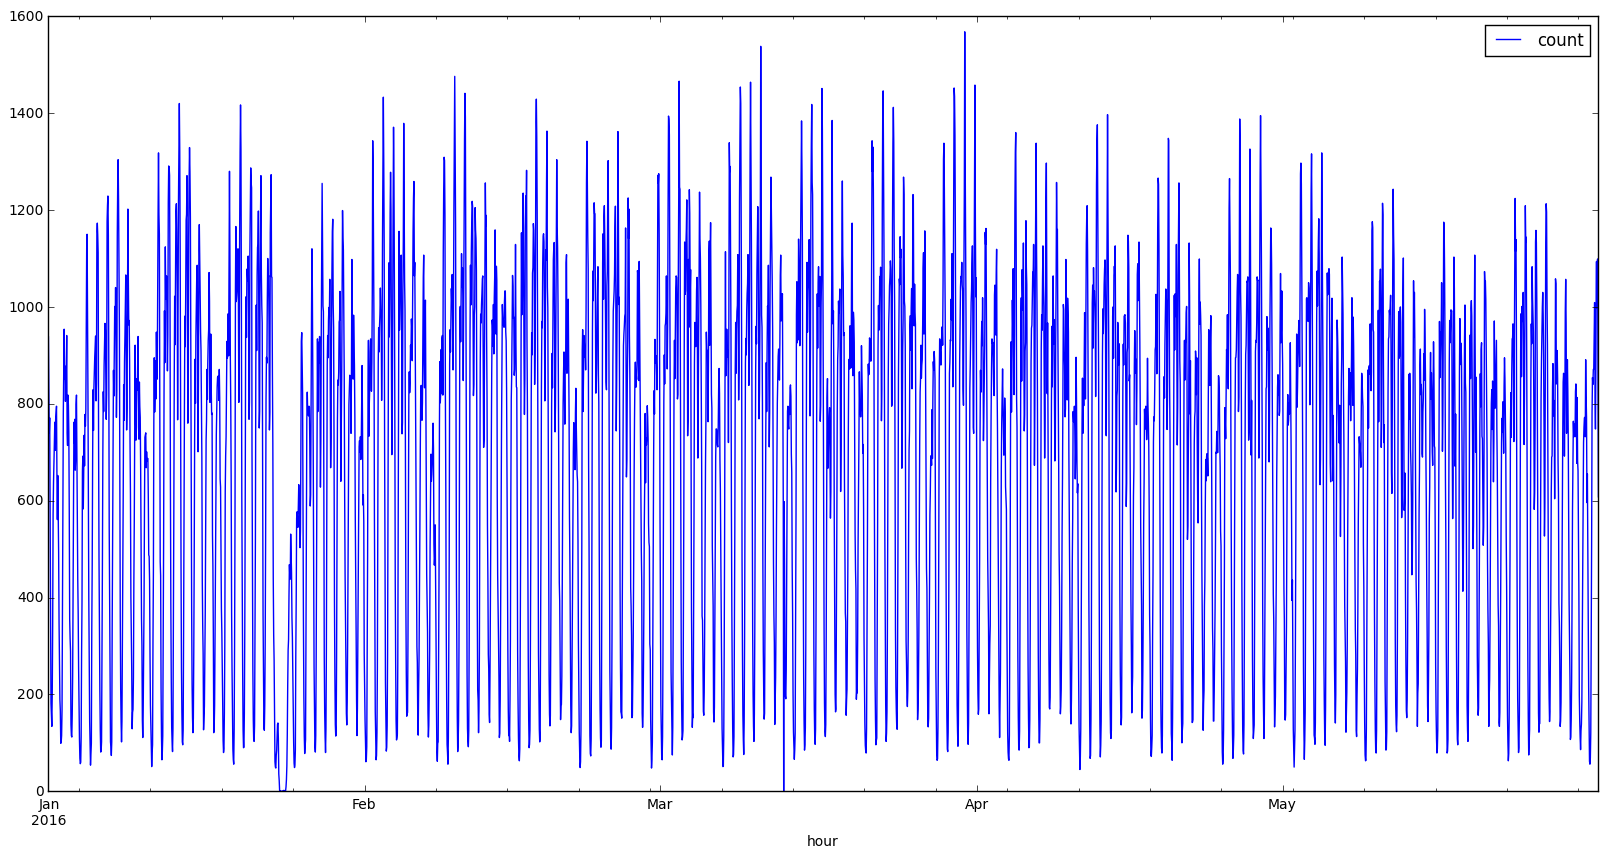

In [258]:
from matplotlib import pyplot as plt
%matplotlib inline 
regions_hour[(regions_hour.west<=-73.985909)&(regions_hour.east>=-73.985909)&
             (regions_hour.south<=40.748458)&(regions_hour.north>=40.748458)&(regions_hour.count>0)]\
            [['hour', 'count']].sort(['hour'], ascending=[1]).plot(x='hour', y='count', figsize=(20, 10))

#### Посмотрим на спады в январе и марте, могут прикодтся как фичи

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


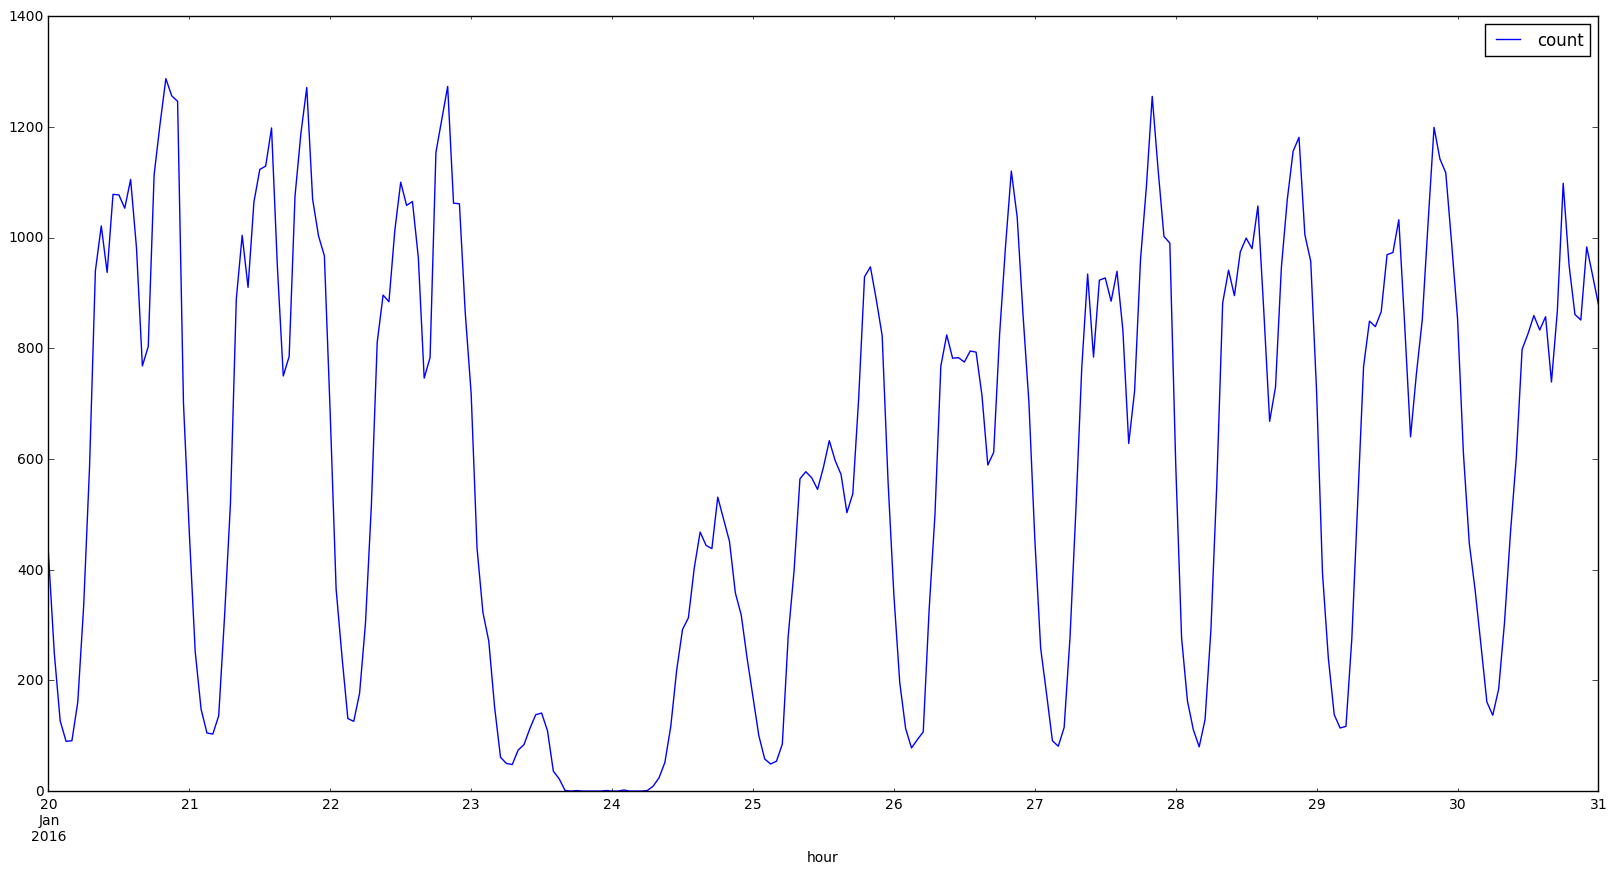

In [62]:
regions_hour[(regions_hour.west<=-73.985909)&(regions_hour.east>=-73.985909)&
             (regions_hour.south<=40.748458)&(regions_hour.north>=40.748458)&
             (regions_hour.count>0)&(regions_hour.hour>='2016-01-20 00:00:00')&(regions_hour.hour<='2016-01-31 00:00:00')]\
            [['hour', 'count']].sort(['hour'], ascending=[1]).plot(x='hour', y='count', figsize=(20, 10))

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


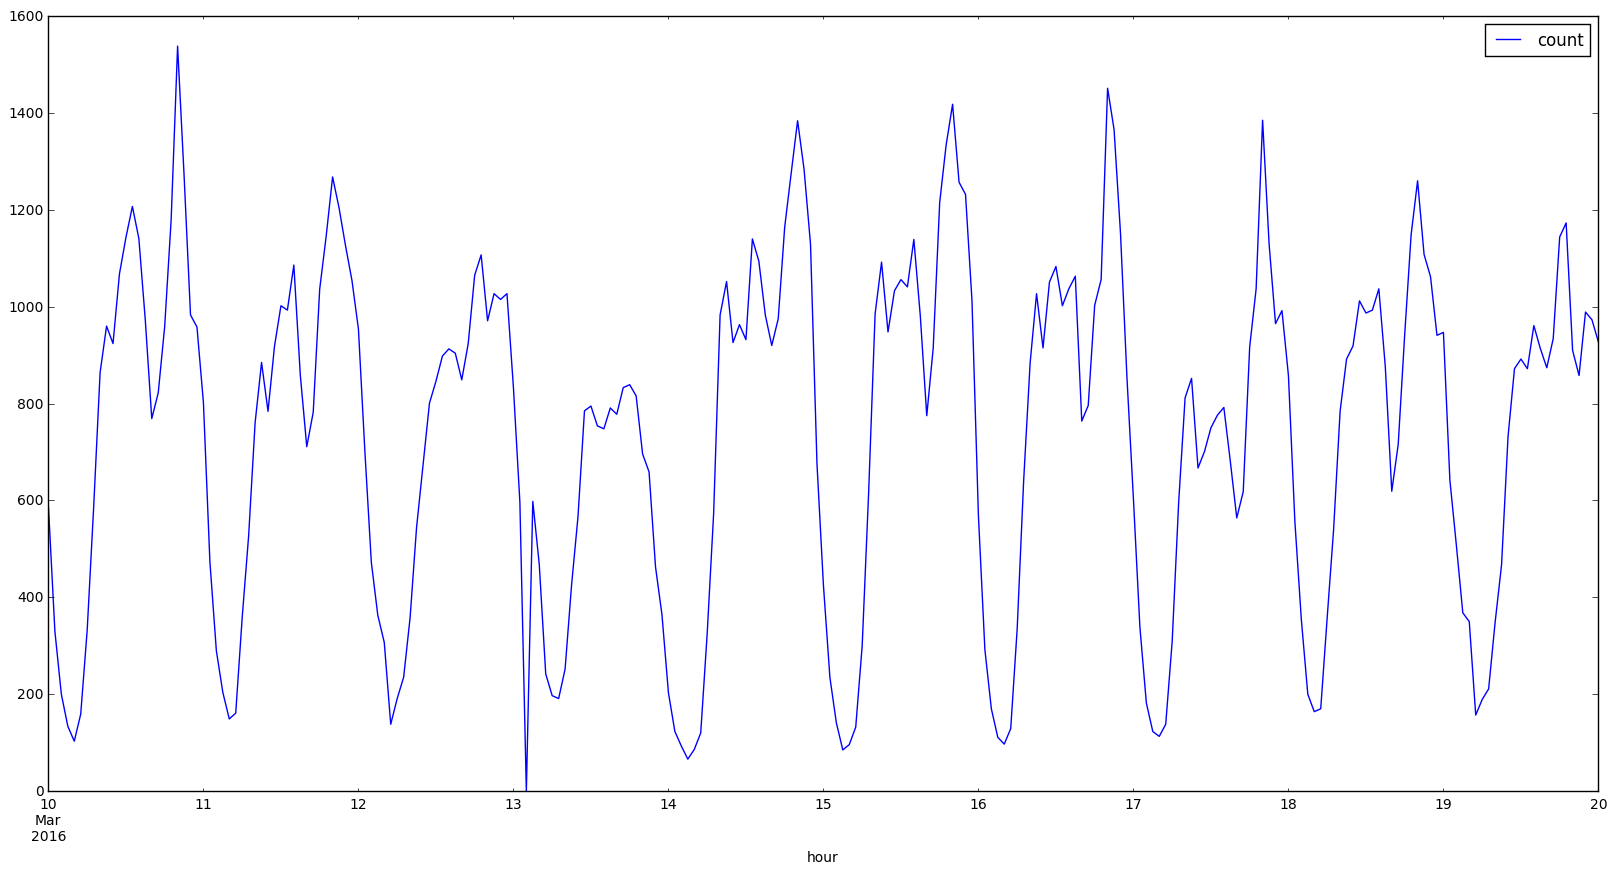

In [63]:
regions_hour[(regions_hour.west<=-73.985909)&(regions_hour.east>=-73.985909)&
             (regions_hour.south<=40.748458)&(regions_hour.north>=40.748458)&
             (regions_hour.count>0)&(regions_hour.hour>='2016-03-10 00:00:00')&(regions_hour.hour<='2016-03-20 00:00:00')]\
            [['hour', 'count']].sort(['hour'], ascending=[1]).plot(x='hour', y='count', figsize=(20, 10))

## Как будем работать

## Еще важное замечание о порядке действий
1. январь-апрель обучение линейной регрессии, май предсказываем
2. вычли из мая то что предсказали. Так мы убрали недельный тренд. (результат пункта 2)
3. провели преобразования Бокса кокса, один раз продифференцировали результат пункта 2, получили (результат пункта 3)
4. Обучили АРИМу на результат пункта 3 (а это все еще май!)
5. Провели обратные преобразования и посмотрели похож ли май на май

### Вот хочется прогнозировать поездки из квадрата где находится LaGuardia Airport (40.774565, -73.872889)

In [94]:
#его координаты
regions[(regions.west<-73.872889) & (regions.east>-73.872889) & 
        (regions.south<40.774565) & (regions.north>40.774565)]

,region,west,east,south,north
1733,1734,-73.877796,-73.866684,40.772931,40.781319


In [4]:
regions_hour[(regions_hour.west<-73.872889) & (regions_hour.east>-73.872889) & 
             (regions_hour.south<40.774565) & (regions_hour.north>40.774565)]

,region,west,east,south,north,hour,count
1733,1734,-73.877796,-73.866684,40.772931,40.781319,2016-01-01 00:00:00,44.0
4233,1734,-73.877796,-73.866684,40.772931,40.781319,2016-01-01 01:00:00,2.0
6733,1734,-73.877796,-73.866684,40.772931,40.781319,2016-01-01 02:00:00,0.0
9233,1734,-73.877796,-73.866684,40.772931,40.781319,2016-01-01 03:00:00,4.0
11733,1734,-73.877796,-73.866684,40.772931,40.781319,2016-01-01 04:00:00,1.0
14233,1734,-73.877796,-73.866684,40.772931,40.781319,2016-01-01 05:00:00,7.0
16733,1734,-73.877796,-73.866684,40.772931,40.781319,2016-01-01 06:00:00,14.0
19233,1734,-73.877796,-73.866684,40.772931,40.781319,2016-01-01 07:00:00,15.0
21733,1734,-73.877796,-73.866684,40.772931,40.781319,2016-01-01 08:00:00,93.0
24233,1734,-73.877796,-73.866684,40.772931,40.781319,2016-01-01 09:00:00,55.0


### отсортируем по региону и времени и добавим фичи

In [5]:
regions_hour_sort=regions_hour[ (regions_hour.west<-73.872889) & (regions_hour.east>-73.872889) & 
                                (regions_hour.south<40.774565) & (regions_hour.north>40.774565)][['region','hour','count']].sort_values(['region','hour']).reset_index()
del regions_hour_sort['index']
regions_hour_sort=regions_hour_sort.reset_index()

Подберем K от 2 до 5 и померим score, будем использовать Ridge регрессию

In [7]:
from sklearn.linear_model import Lasso, Ridge


for K in range(1,6):
#K=5
    for i in range(1,K+1):
        #print 'fk'+str(i)
        regions_hour_sort['sink'+str(i)]=np.sin(regions_hour_sort.index*2*np.pi*i/168.0)
        regions_hour_sort['cosk'+str(i)]=np.cos(regions_hour_sort.index*2*np.pi*i/168.0)
    features=list(set(regions_hour_sort.columns)-set([u'x', u'region', u'hour', u'count']))

    ridge=Ridge()
    #ridge.fit(df.iloc[:,:-1], df['cnt'])
    #zip(ridge.coef_, df.columns)

    ridge.fit(
        regions_hour_sort[(regions_hour_sort.hour>='2016-01-01 00:00:00')&
                                (regions_hour_sort.hour<='2016-05-01 00:00:00')][features],
        regions_hour_sort[(regions_hour_sort.hour>='2016-01-01 00:00:00')&
                            (regions_hour_sort.hour<='2016-05-01 00:00:00')]['count'])
    #zip(ridge.coef_, features)
    score=ridge.score(regions_hour_sort[(regions_hour_sort.hour>='2016-05-01 00:00:00')&
                                (regions_hour_sort.hour<='2016-06-01 00:00:00')][features],
               regions_hour_sort[(regions_hour_sort.hour>='2016-05-01 00:00:00')&
                            (regions_hour_sort.hour<='2016-06-01 00:00:00')]['count'])
    for j in features:
        del regions_hour_sort[j]
    print 'K=', K, ' score=', score 

K= 1  score= 0.0391769833636
K= 2  score= 0.0578576500379
K= 3  score= 0.0685038399529
K= 4  score= 0.0728912296113
K= 5  score= 0.0771017222251


Повторим все это дело для лучшго K=4

In [86]:
K=4
for i in range(1,K+1):
    #print 'fk'+str(i)
    regions_hour_sort['sink'+str(i)]=np.sin(regions_hour_sort.index*2*np.pi*i/168.0)
    regions_hour_sort['cosk'+str(i)]=np.cos(regions_hour_sort.index*2*np.pi*i/168.0)
features=list(set(regions_hour_sort.columns)-set([u'x', u'region', u'hour', u'count']))

ridge=Ridge(alpha=1)
#ridge.fit(df.iloc[:,:-1], df['cnt'])
#zip(ridge.coef_, df.columns)

ridge.fit(
    regions_hour_sort[(regions_hour_sort.hour>='2016-01-01 00:00:00')&
                            (regions_hour_sort.hour<='2016-05-01 00:00:00')][features],
    regions_hour_sort[(regions_hour_sort.hour>='2016-01-01 00:00:00')&
                        (regions_hour_sort.hour<='2016-05-01 00:00:00')]['count'])

res=ridge.predict(regions_hour_sort[(regions_hour_sort.hour>='2016-05-01 00:00:00')&
                            (regions_hour_sort.hour<='2016-06-01 00:00:00')][features])
y=regions_hour_sort[(regions_hour_sort.hour>='2016-05-01 00:00:00')&
                        (regions_hour_sort.hour<='2016-06-01 00:00:00')]['count']
x=regions_hour_sort[(regions_hour_sort.hour>='2016-05-01 00:00:00')&
                        (regions_hour_sort.hour<='2016-06-01 00:00:00')].index

## y это counts за май (true количесват поездок из ячейки по часам)

In [87]:
y.index=regions_hour_sort[(regions_hour_sort.hour>='2016-05-01 00:00:00')&
                        (regions_hour_sort.hour<='2016-06-01 00:00:00')]['hour']
y=pd.DataFrame(y)
y.columns=[u'counts']

Попробуем xgboost, получатся похожие результаты

In [89]:
import xgboost as xgb
X_train = regions_hour_sort[(regions_hour_sort.hour>='2016-01-01 00:00:00')&
                            (regions_hour_sort.hour<='2016-05-01 00:00:00')][features]
Y_train = regions_hour_sort[(regions_hour_sort.hour>='2016-01-01 00:00:00')&
                        (regions_hour_sort.hour<='2016-05-01 00:00:00')]['count']
T_train_xgb = xgb.DMatrix(X_train, Y_train)

params = {"objective": "reg:linear", "booster":"gblinear"}
gbm = xgb.train(dtrain=T_train_xgb,params=params)
Y_pred = gbm.predict(xgb.DMatrix(regions_hour_sort[(regions_hour_sort.hour>='2016-05-01 00:00:00')&
                            (regions_hour_sort.hour<='2016-06-01 00:00:00')][features]))
y['xgb_counts']=Y_pred

[ 104.52098083  108.91892242  114.04592896  119.84779358  126.26141357
  133.21589661  140.63357544  148.43118286  156.52156067  164.81474304
  173.21942139  181.64468384  190.00106812  198.20217896  206.16600037
  213.81608582  221.08255005  227.90319824  234.22424316  240.00090027
  245.19805908  249.79032898  253.76226807  257.10824585  259.83221436
  261.94717407  263.47488403  264.44464111  264.89282227  264.86172485
  264.39849854  263.55422974  262.38250732  260.93850708  259.27764893
  257.45465088  255.52233887  253.53065491  251.52597046  249.55004883
  247.63961792  245.82579041  244.13366699  242.58215332  241.18391418
  239.94538879  238.86723328  237.94432068  237.16650391  236.519104
  235.98352051  235.53813171  235.15890503  234.82029724  234.49612427
  234.16036987  233.78790283  233.3553009   232.84159851  232.22879028
  231.50216675  230.65124512  229.66946411  228.55470276  227.30924988
  225.93972778  224.45690918  222.8754425   221.21342468  219.49183655
  217.73

In [59]:
# regions_hour_sort['dayofweek']=regions_hour_sort.hour.dt.dayofweek
# regions_hour_sort['is_sunday']=regions_hour_sort.dayofweek.apply(lambda x: 1 if (x==6) else 0)
# del regions_hour_sort['dayofweek']

In [31]:
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
from itertools import product

Норисуем наш недельный тренд и остатки

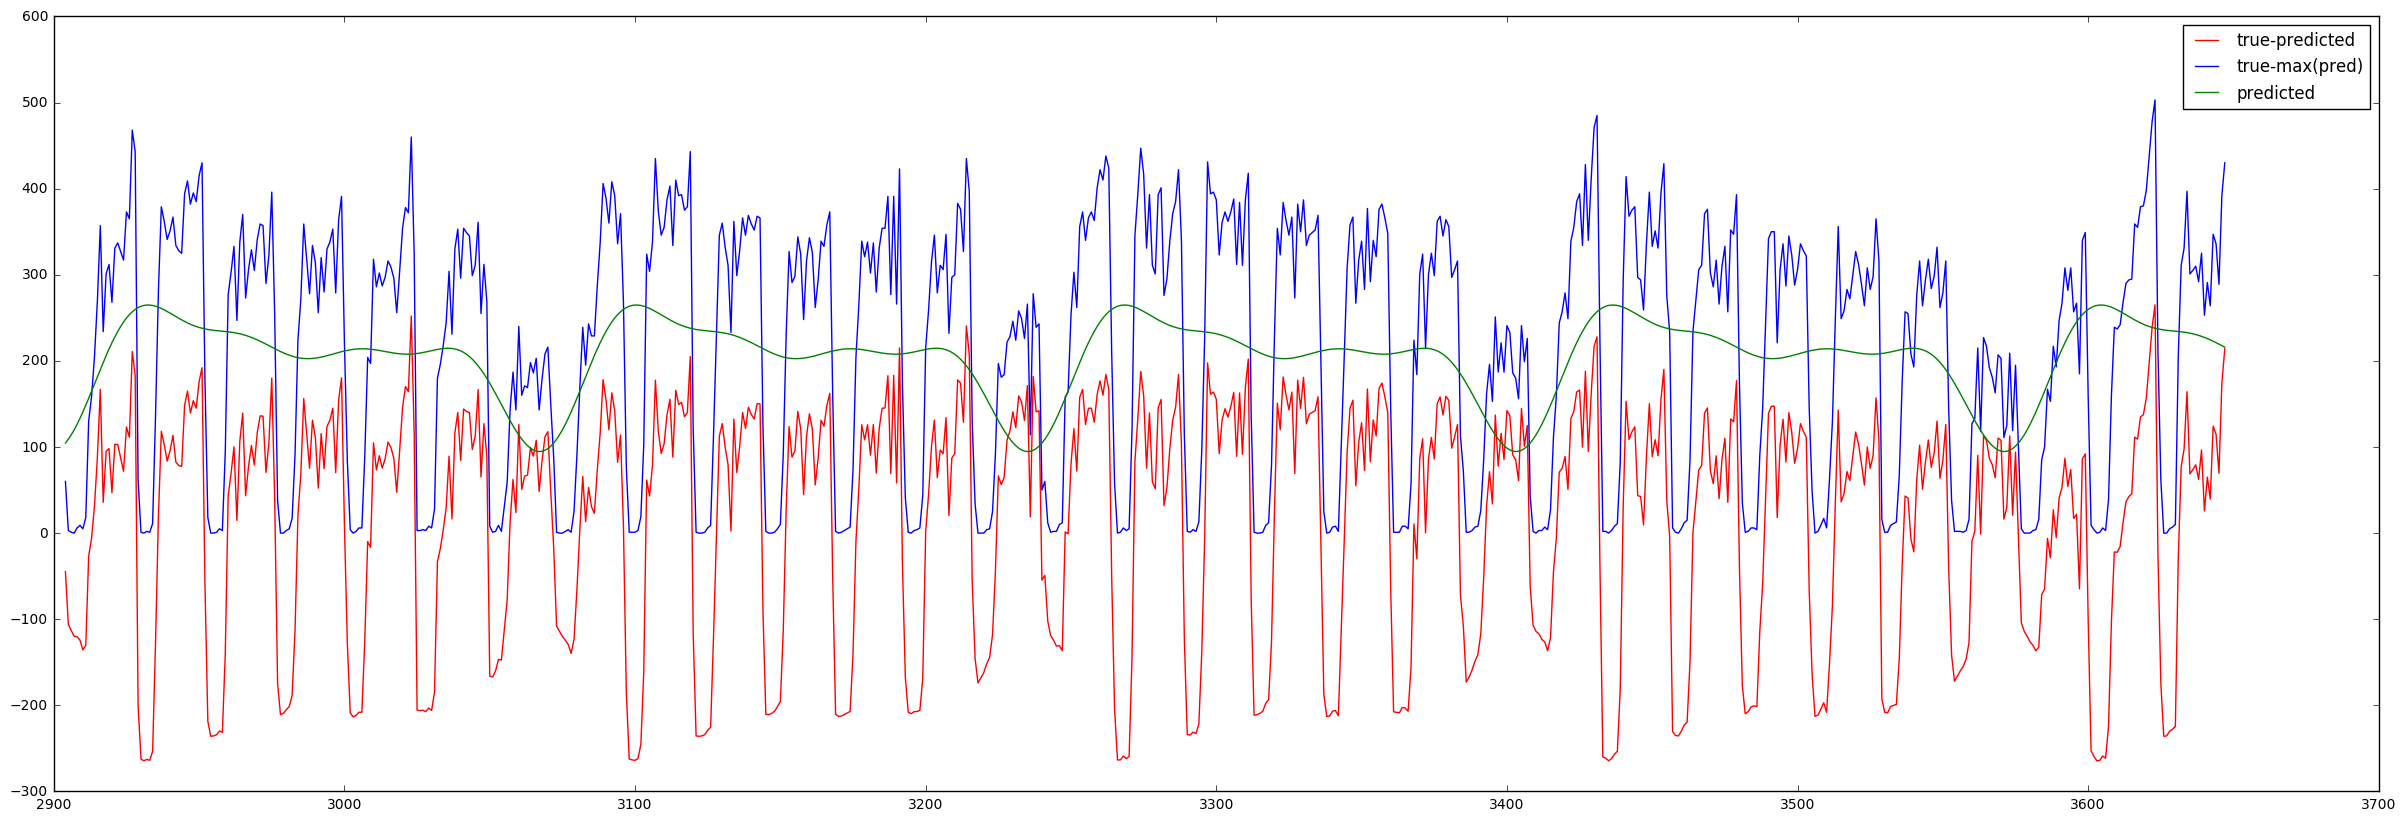

In [162]:

plt.figure(figsize=(30, 10))
plt.plot(x, y['counts']-res, color='r', label='true-predicted')
plt.plot(x, y['counts'], color='b', label='true')
#plt.plot(x, y['counts']-y['xgb_counts'], color='r', label='true')
plt.plot(x, res, color='g', label='predicted')
plt.legend()

Посмотрим на STL декомпозицию исходного ряда и увидим тренд похожий на наш недельный

Критерий Дики-Фуллера: p=0.000912


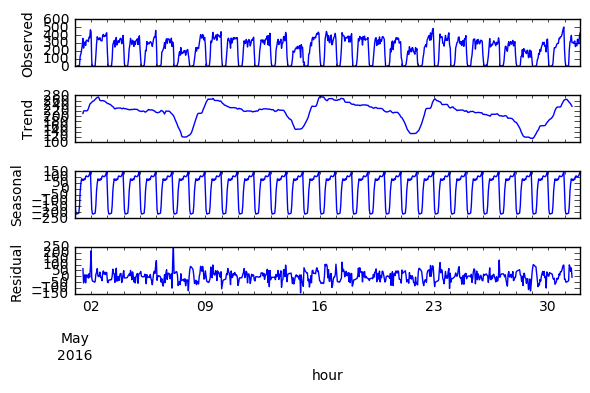

In [101]:
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(y.counts).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y.counts)[1])

Теперь посмотрим на STL декомпозицию наших остатков и увидим мнее заметный тренд, кроме последней недели, там что-то не так, нужно будет наверное добавлять доп. фичи

Критерий Дики-Фуллера: p=0.000000


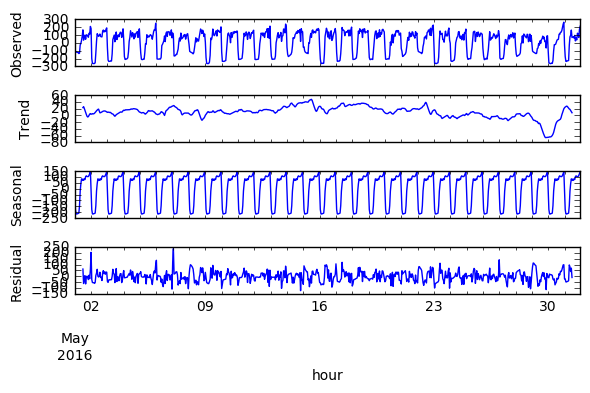

In [102]:
y['y_minus_preds']=y['counts']-res
sm.tsa.seasonal_decompose(y['y_minus_preds']).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y['y_minus_preds'])[1])

Критерий дики-фуллера нас обманывает, уверенно отвергая не стационарность ряда, так что смотрим только на STL декомпозицию

In [104]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Пробуем стабилизацию дисперсию с помощью преобразования бокса-кокса
прибавляем np.max(res) это максимальное значение предсказанных результатов, нужно не забыть отнять потом. Т.е. будет вконце обратное преобразование бокса кокса - np.max(res)

Оптимальный параметр преобразования Бокса-Кокса: 0.977860
Критерий Дики-Фуллера: p=0.000000


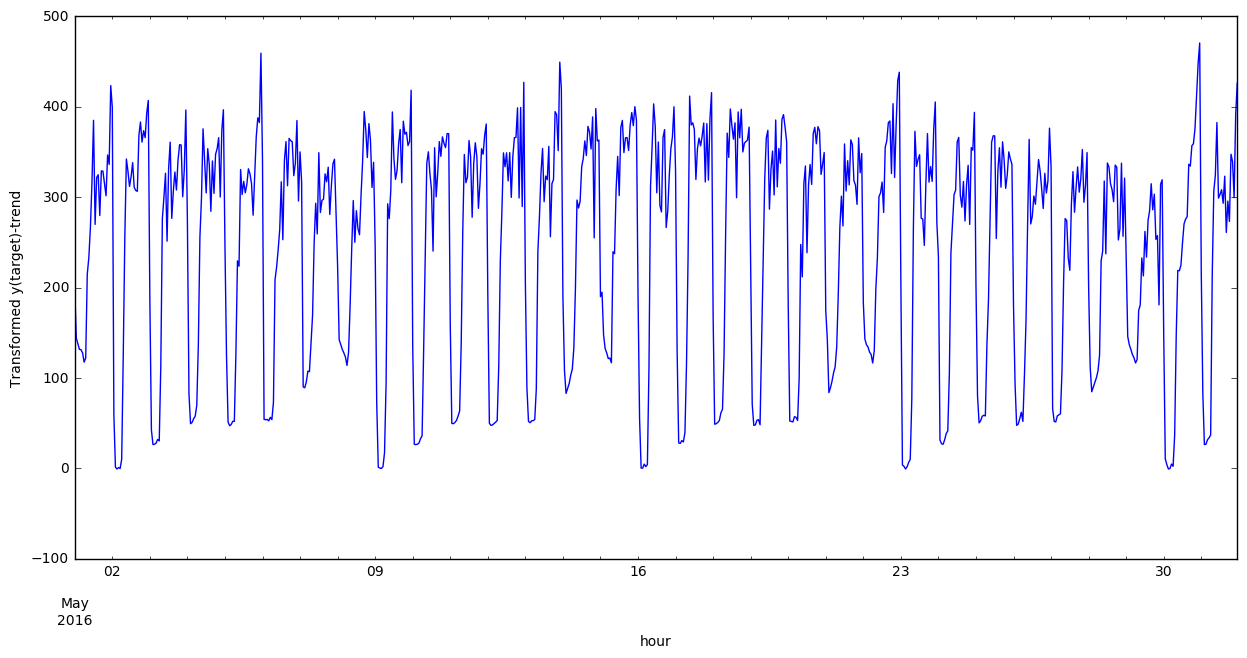

In [114]:
y['y_minus_preds_box'], lmbda = stats.boxcox(y.y_minus_preds+np.max(res))
plt.figure(figsize=(15,7))
y.y_minus_preds_box.plot()
#y.counts.plot()
plt.ylabel(u'Transformed y(target)-trend')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y.y_minus_preds_box)[1])

Добавим сезонное дифференцирование = 24 часа

Критерий Дики-Фуллера: p=0.000000


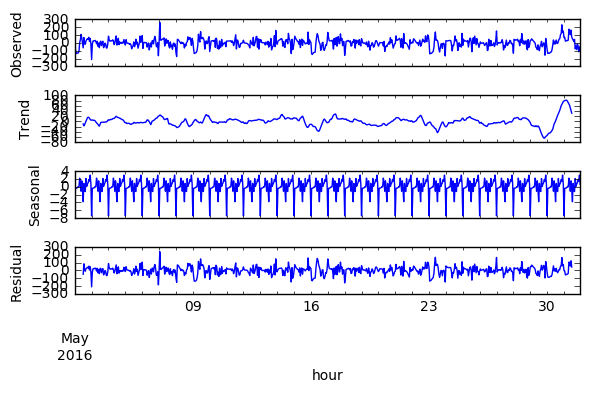

In [125]:
y['y_minus_preds_box_diff24'] = y.y_minus_preds_box - y.y_minus_preds_box.shift(24)
plt.figure(figsize=(60,30))
sm.tsa.seasonal_decompose(y.y_minus_preds_box_diff24[24:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y.y_minus_preds_box_diff24[24:])[1])

Видно что после сезонного фифференцирования ряд стал похож на стационарный

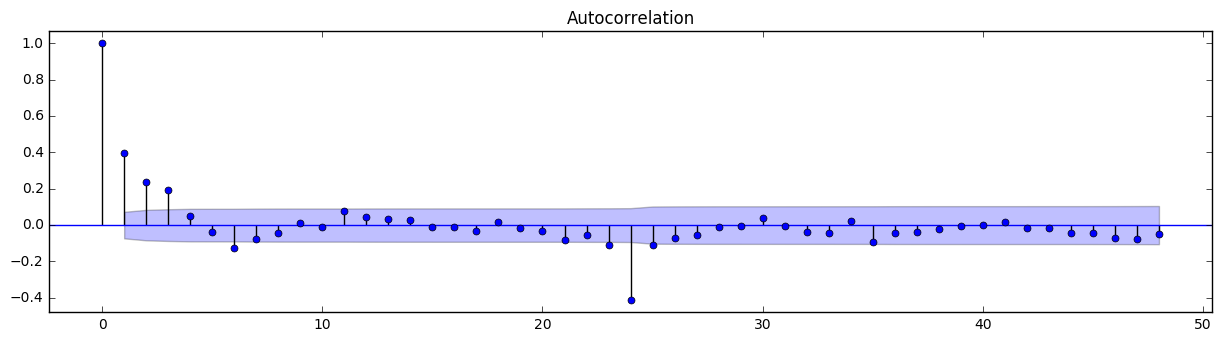

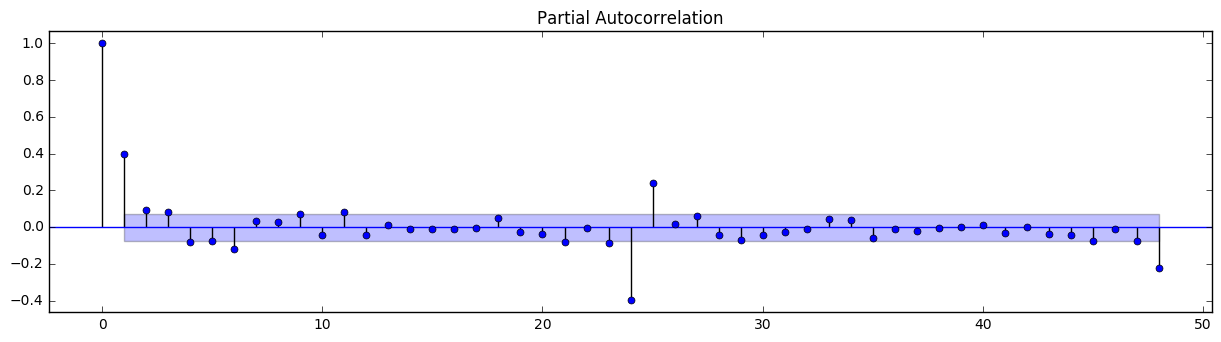

In [131]:
#%pylab inline
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(y.y_minus_preds_box_diff24[24:].values.squeeze(), lags=48, ax=ax)
plt.show()
plt.figure(figsize=(15,8))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(y.y_minus_preds_box_diff24[24:].values.squeeze(), lags=48, ax=ax)
plt.show()

In [136]:
from itertools import product
Q=1
q=3
P=2
p=1

ps = range(0, p+1)
d=1
qs = range(0, q+1)
Ps = range(0, P+1)
D=1
Qs = range(0, Q+1)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

48

In [150]:
parameters_list

[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 0, 2, 0),
 (0, 0, 2, 1),
 (0, 1, 0, 0),
 (0, 1, 0, 1),
 (0, 1, 1, 0),
 (0, 1, 1, 1),
 (0, 1, 2, 0),
 (0, 1, 2, 1),
 (0, 2, 0, 0),
 (0, 2, 0, 1),
 (0, 2, 1, 0),
 (0, 2, 1, 1),
 (0, 2, 2, 0),
 (0, 2, 2, 1),
 (0, 3, 0, 0),
 (0, 3, 0, 1),
 (0, 3, 1, 0),
 (0, 3, 1, 1),
 (0, 3, 2, 0),
 (0, 3, 2, 1),
 (1, 0, 0, 0),
 (1, 0, 0, 1),
 (1, 0, 1, 0),
 (1, 0, 1, 1),
 (1, 0, 2, 0),
 (1, 0, 2, 1),
 (1, 1, 0, 0),
 (1, 1, 0, 1),
 (1, 1, 1, 0),
 (1, 1, 1, 1),
 (1, 1, 2, 0),
 (1, 1, 2, 1),
 (1, 2, 0, 0),
 (1, 2, 0, 1),
 (1, 2, 1, 0),
 (1, 2, 1, 1),
 (1, 2, 2, 0),
 (1, 2, 2, 1),
 (1, 3, 0, 0),
 (1, 3, 0, 1),
 (1, 3, 1, 0),
 (1, 3, 1, 1),
 (1, 3, 2, 0),
 (1, 3, 2, 1)]

In [147]:
y.loc[y['y_minus_preds_box']<0, 'y_minus_preds_box']=0.0

In [164]:
y[u'counts',u'xgb_counts',u'preds', u'y_minus_preds',u'y_minus_preds_box', u'y_minus_preds_box_diff24', u'model']

Index([                  u'counts',               u'xgb_counts',
                          u'preds',            u'y_minus_preds',
              u'y_minus_preds_box', u'y_minus_preds_box_diff24',
                          u'model'],
      dtype='object')

In [153]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    
    try:
        print param
        model=sm.tsa.statespace.SARIMAX(y['y_minus_preds_box'].values, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
warnings.filterwarnings('default')

(0, 0, 0, 0)
('wrong parameters:', (0, 0, 0, 0))
(0, 0, 0, 1)
(0, 0, 1, 0)
(0, 0, 1, 1)
(0, 0, 2, 0)
(0, 0, 2, 1)
(0, 1, 0, 0)
(0, 1, 0, 1)
(0, 1, 1, 0)
(0, 1, 1, 1)
(0, 1, 2, 0)
(0, 1, 2, 1)
(0, 2, 0, 0)
(0, 2, 0, 1)
(0, 2, 1, 0)
(0, 2, 1, 1)
(0, 2, 2, 0)
(0, 2, 2, 1)
(0, 3, 0, 0)
(0, 3, 0, 1)
(0, 3, 1, 0)
(0, 3, 1, 1)
(0, 3, 2, 0)
(0, 3, 2, 1)
(1, 0, 0, 0)
(1, 0, 0, 1)
(1, 0, 1, 0)
(1, 0, 1, 1)
(1, 0, 2, 0)
(1, 0, 2, 1)
(1, 1, 0, 0)
(1, 1, 0, 1)
(1, 1, 1, 0)
(1, 1, 1, 1)
(1, 1, 2, 0)
(1, 1, 2, 1)
(1, 2, 0, 0)
('wrong parameters:', (1, 2, 0, 0))
(1, 2, 0, 1)
('wrong parameters:', (1, 2, 0, 1))
(1, 2, 1, 0)
('wrong parameters:', (1, 2, 1, 0))
(1, 2, 1, 1)
('wrong parameters:', (1, 2, 1, 1))
(1, 2, 2, 0)
('wrong parameters:', (1, 2, 2, 0))
(1, 2, 2, 1)
('wrong parameters:', (1, 2, 2, 1))
(1, 3, 0, 0)
(1, 3, 0, 1)
(1, 3, 1, 0)
(1, 3, 1, 1)
(1, 3, 2, 0)
(1, 3, 2, 1)
CPU times: user 26min 37s, sys: 5.68 s, total: 26min 43s
Wall time: 26min 43s


In [155]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
30  (1, 1, 0, 1)  7368.548781
34  (1, 1, 2, 1)  7372.225341
36  (1, 3, 0, 1)  7372.618453
32  (1, 1, 1, 1)  7374.576093
38  (1, 3, 1, 1)  7374.975033


In [156]:
print(best_model.summary())


                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  744
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 24)   Log Likelihood               -3680.274
Date:                            Sun, 16 Apr 2017   AIC                           7368.549
Time:                                    20:28:05   BIC                           7386.997
Sample:                                         0   HQIC                          7375.660
                                            - 744                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4435      0.030     14.932      0.000       0.385       0.502
ma.L1         -0.9861      0.009   

Остатки модели

Критерий Стьюдента: p=0.478340
Критерий Дики-Фуллера: p=0.000000


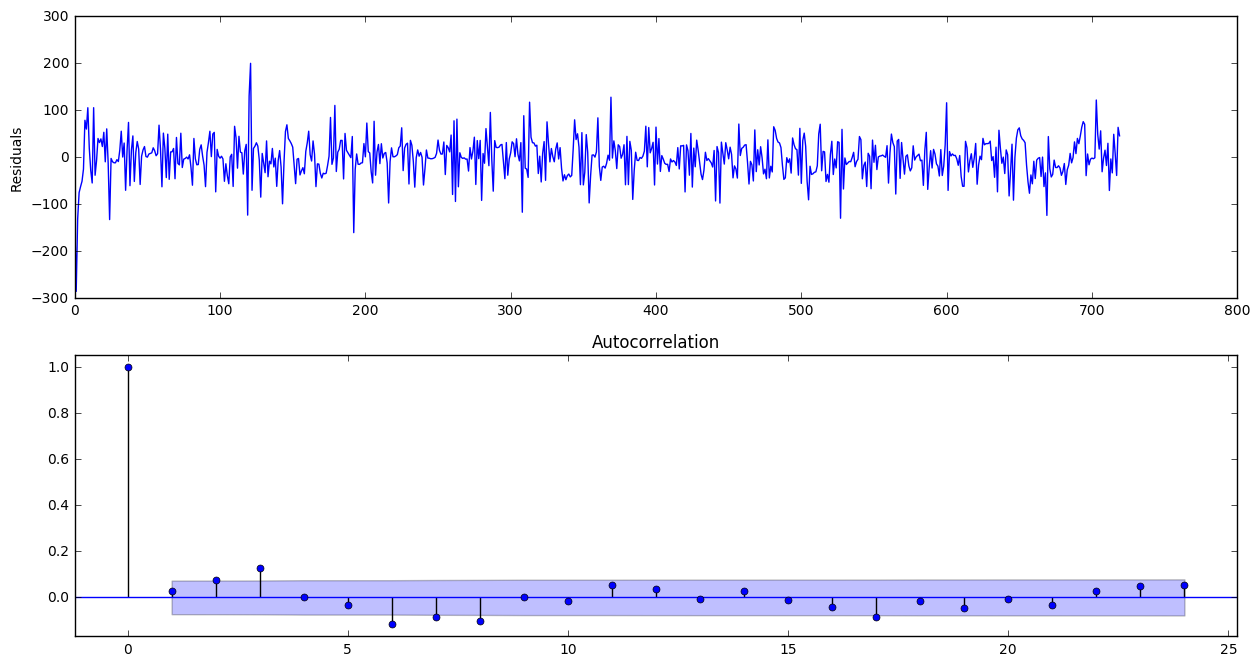

In [165]:
plt.figure(figsize(15,8))
plt.subplot(211)
plt.plot(best_model.resid[24:])
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[24:], lags=24, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[24:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[24:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).

### Важно аккуратно провести обратные операции, у меня вычитание константы что я прибавляля что бы провести преобразование Бокса-кокса (np.max(res)), j,обратное преобразование бокса кокса, прибавление вычтенного тренда (res)

Посмотрим, насколько хорошо модель описывает данные:

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log


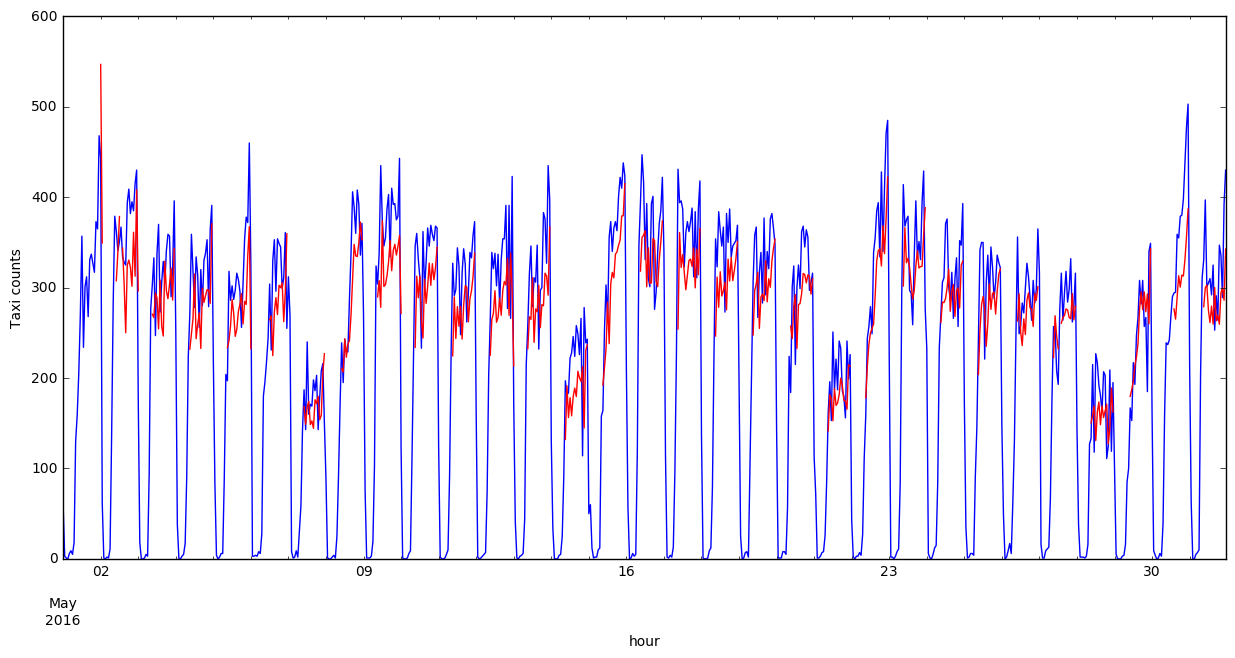

In [168]:
y['model'] = invboxcox(best_model.fittedvalues-np.max(res), lmbda)+res
plt.figure(figsize(15,7))
y.counts.plot()
y.model[24:].plot(color='r')
plt.ylabel('Taxi counts')
pylab.show()

### Модель описывает данные не плохо, есть небольшие отклонения но наверное жто не учтенная годовая сезонность